<a href="https://colab.research.google.com/github/Yoshiki0418/-Generation-AI/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### DCGANの

Notion: https://www.notion.so/DCGAN-13bde7361907810bab75f928958f5441

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F
from torch import optim

In [15]:
# FashionMNISTデータでVAEを試す
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

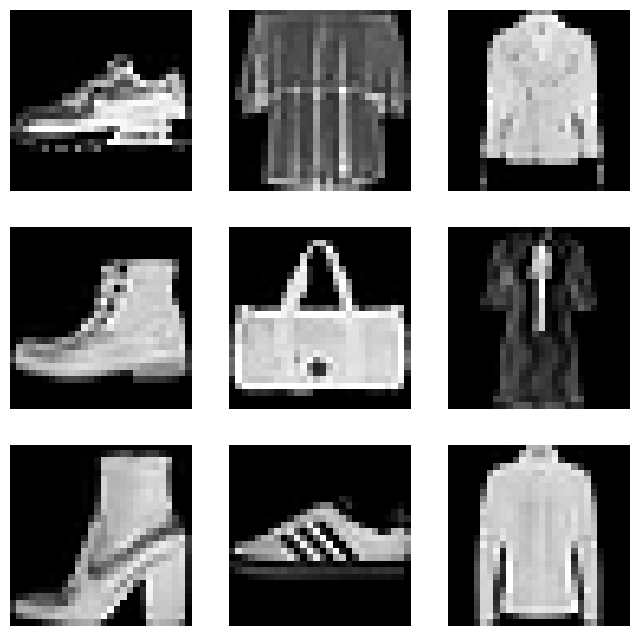

In [16]:
# 入力画像を描画する
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, rows*cols + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [17]:
# ハイパーパラメータ
image_size = 28
n_noise = 100 # ノイズ数
lr = 0.0002
epochs = 40
batch_size = 64

In [18]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

## DCGANを構築

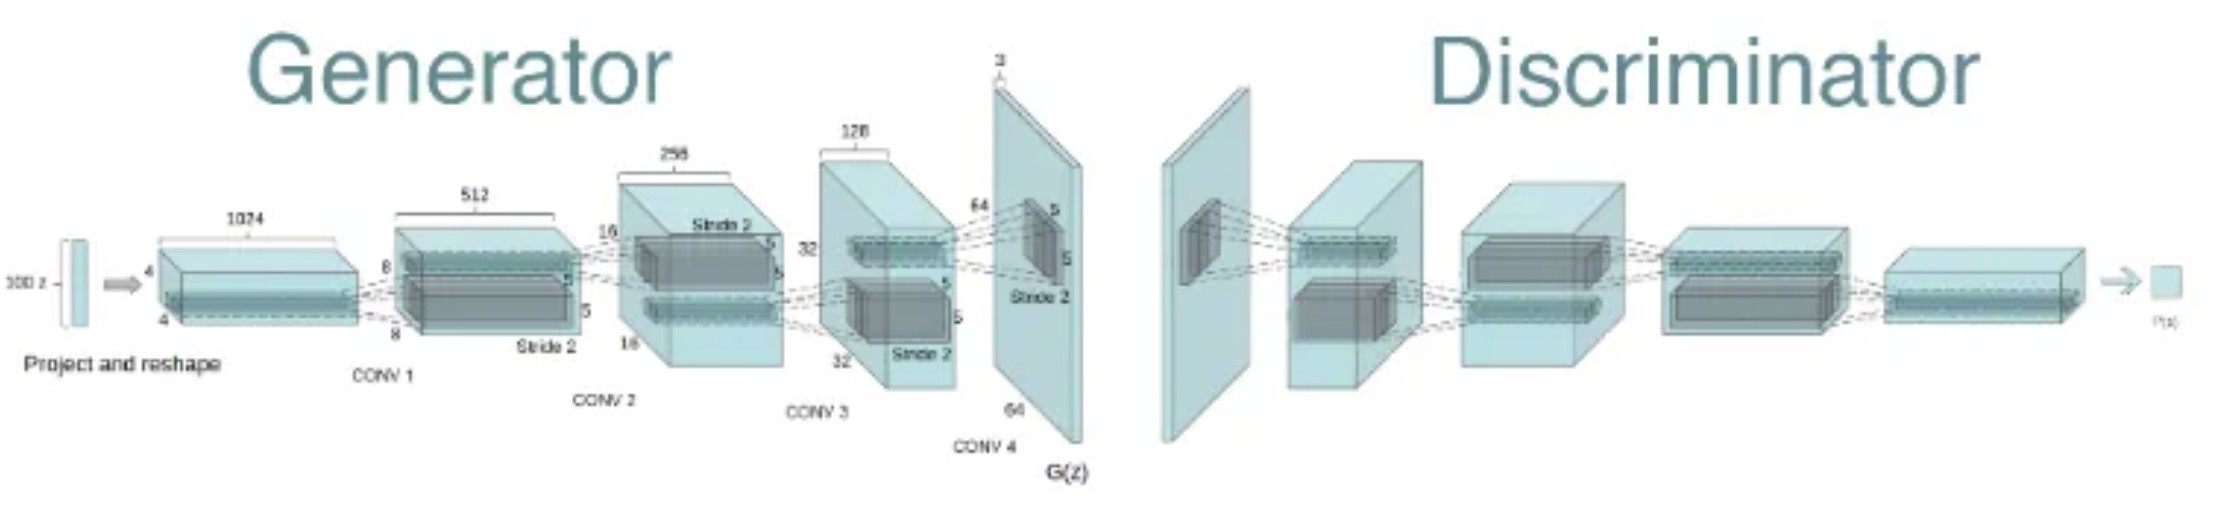

### Generatorの構築

今回、Genetatorで生成したい画像のサイズは28x28であるので、論文のアーキテクチャを参考にしつつ、今回のサイズに合わせたアーキテクチャを採用する。

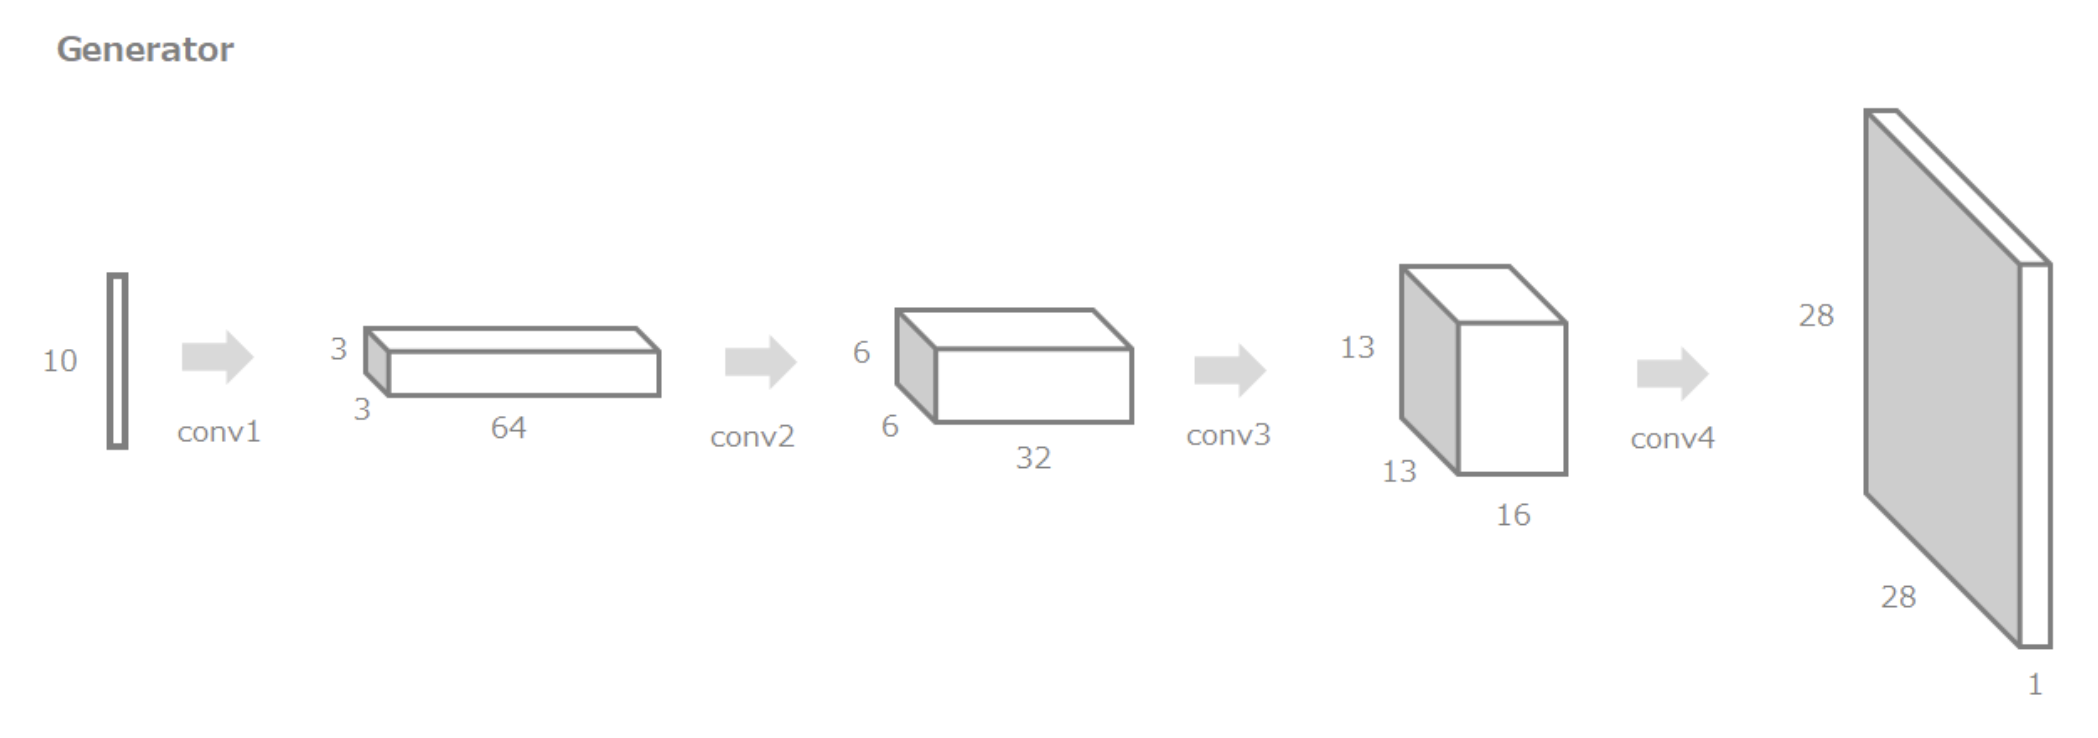

In [26]:
class Generator(nn.Module):
  def __init__(self, n_noise: int):
    super().__init__()

    self.n_noise = n_noise
    self.block1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=n_noise, out_channels=256, kernel_size=3, stride=2),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.block2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    self.block3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2),
        nn.Tanh()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x.view(-1, self.n_noise, 1, 1)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    out = self.final(x)
    return out

In [27]:
generator = Generator(n_noise)
generator.cuda()
print(generator)

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (final): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)


### Discriminatorの構築

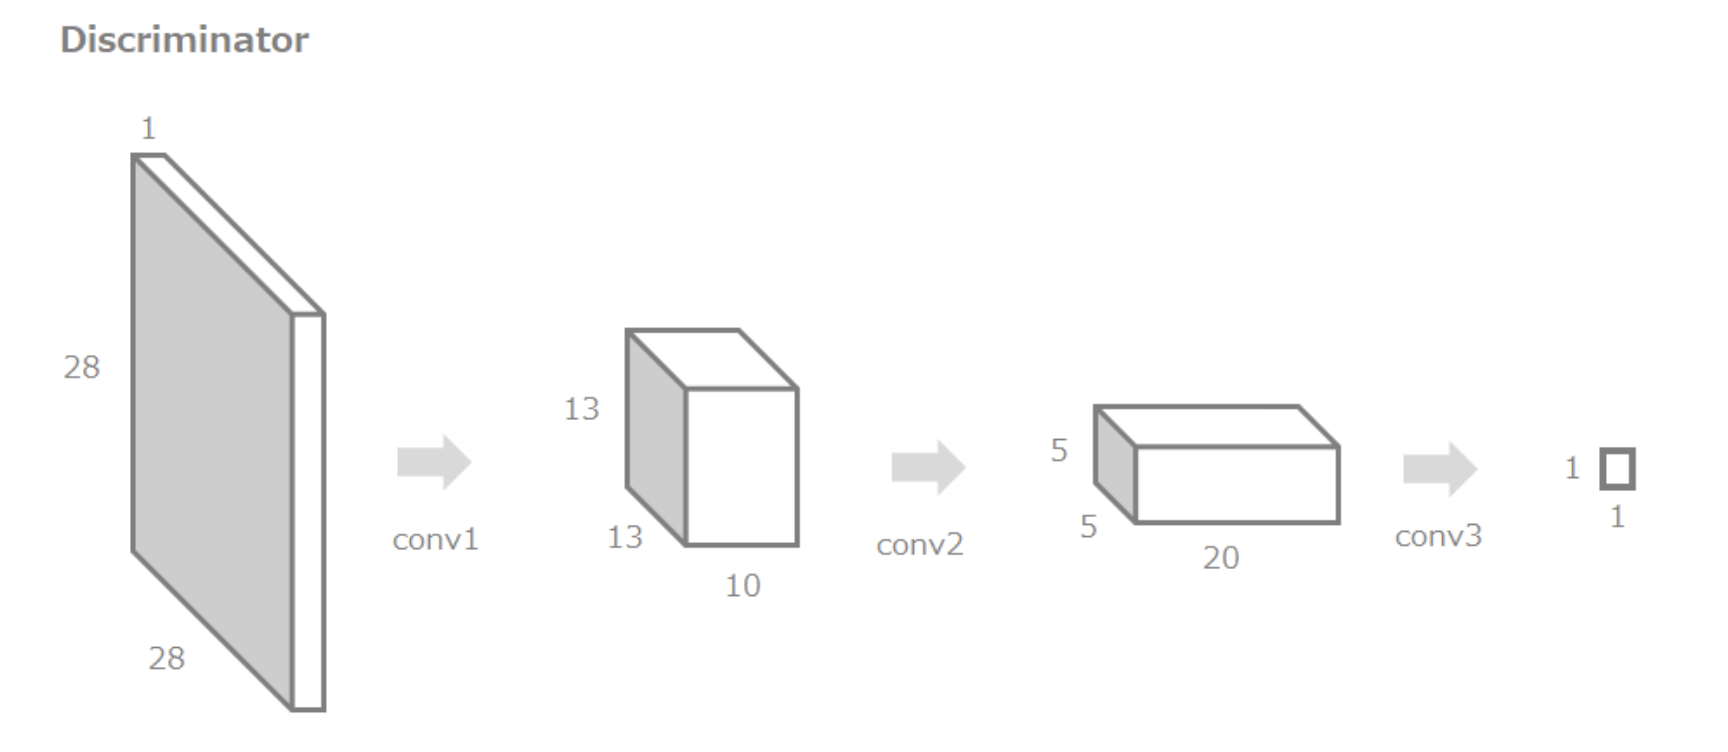

In [29]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(negative_slope=0.2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(negative_slope=0.2)
    )
    self.conv_head = nn.Sequential(
        nn.Conv2d(32, 1, kernel_size=4, stride=2),
        nn.Sigmoid()
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_head(x)
    out = x.view(-1, 1)
    return out

In [31]:
discriminator = Discriminator()
discriminator.cuda()
print(discriminator)

Discriminator(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_head): Sequential(
    (0): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Sigmoid()
  )
)


In [23]:
def generate_images(i, n_noise, image_size):
    # 画像の生成
    rows = 16
    cols = 16
    noise = torch.randn(rows * cols, n_noise).cuda()  # GPUに移動
    generator.cuda()  # generatorモデルもGPUに移動
    imgs = generator(noise)
    imgs = imgs.view(rows*cols, 1, -1)
    imgs = imgs.cpu().detach().numpy()  # 結果をCPUに戻す

    img_size_spaced = image_size + 2
    matrix_image = np.zeros((img_size_spaced * rows, img_size_spaced * cols))

    # 生成された画像を並べて一枚の画像にする
    for r in range(rows):
        for c in range(cols):
            img = imgs[r * cols + c].reshape(image_size, image_size)
            top = r * img_size_spaced
            left = c * img_size_spaced
            matrix_image[top: top + image_size, left: left + image_size] = img

    plt.figure(figsize=(8, 8))
    plt.imshow(matrix_image, cmap="Greys_r", vmin=0.0, vmax=1.0)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.show()

In [24]:
def count_correct(y, t):
  correct = torch.sum((torch.where(y<0.5, 0, 1) ==  t).float())
  return correct.item()

Epochs: 0
Error_fake: 0.7789819234851073 Acc_fake: 0.49775
Error_real: 0.5787411112902261 Acc_real: 0.7392333333333333


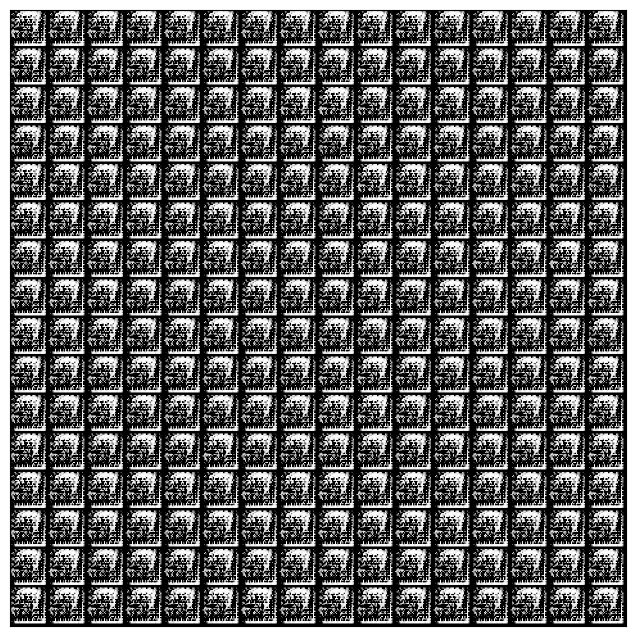

Epochs: 10
Error_fake: 0.7638569899332295 Acc_fake: 0.14071666666666666
Error_real: 0.7675537493056072 Acc_real: 0.23988333333333334


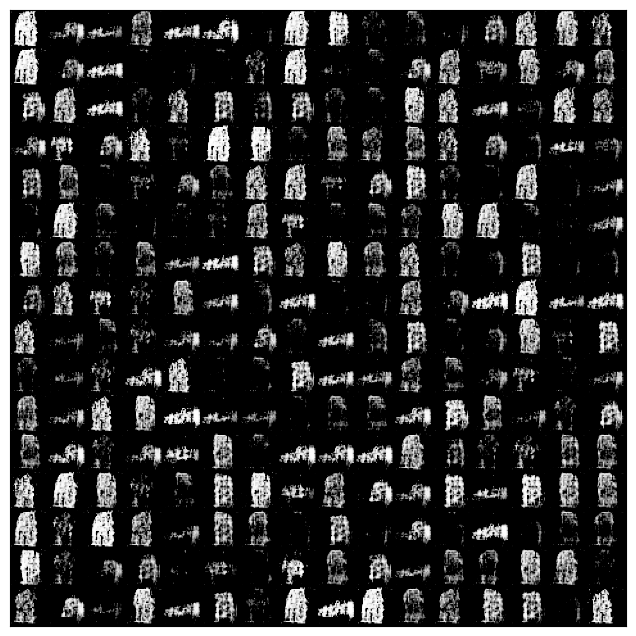

Epochs: 20
Error_fake: 0.7028401354863953 Acc_fake: 0.36165
Error_real: 0.7104548303557358 Acc_real: 0.2749666666666667


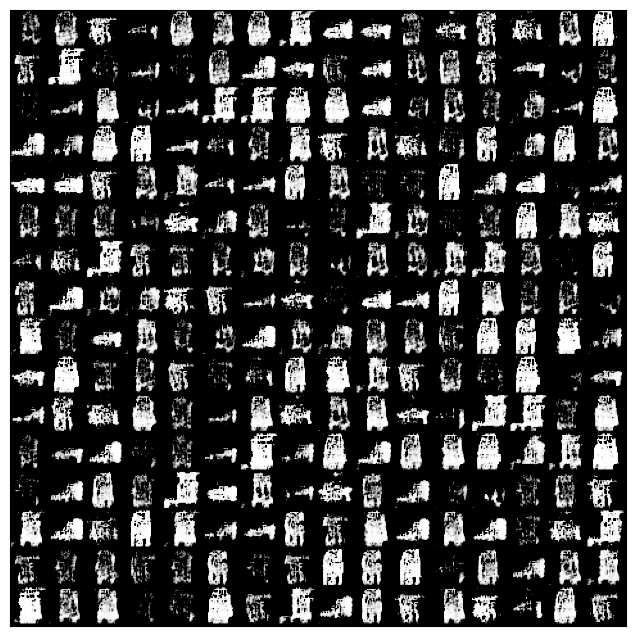

Epochs: 30
Error_fake: 0.7003181068373642 Acc_fake: 0.3880166666666667
Error_real: 0.7055840856993376 Acc_real: 0.3155


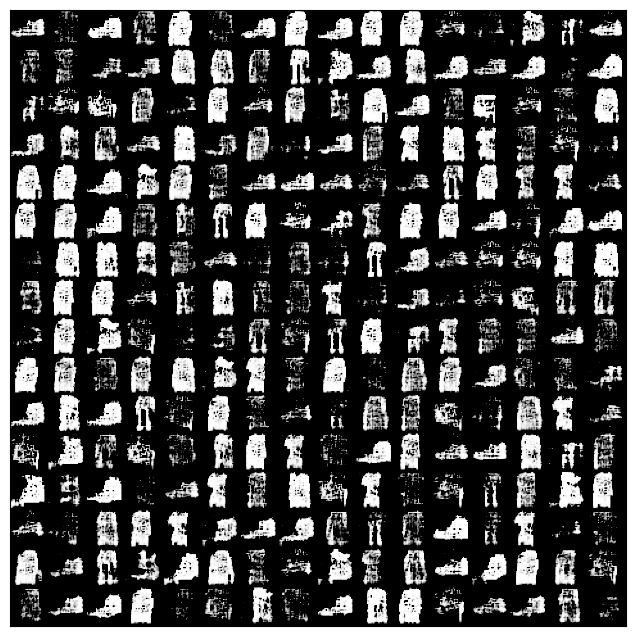

In [32]:
# 二値の交差エントロピー誤差関数
loss_func = nn.BCELoss()

# Adam
optimizer_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# ログ
error_record_fake = []  # 偽物画像の誤差記録
acc_record_fake = []  # 偽物画像の精度記録
error_record_real = []  # 本物画像の誤差記録
acc_record_real = []  # 本物画像の精度記録

# -------------------------------------------
#            DCGAN の学習
# -------------------------------------------
generator.train()
discriminator.train()
for i in range(epochs):
  loss_fake = 0
  correct_fake = 0
  loss_real = 0
  correct_real = 0
  n_total = 0
  for j, (x,_) in enumerate(train_loader):
    n_total += x.size()[0]

    # ノイズからGeneratorで画像を生成し、Discriminatorに偽物画像を与えて訓練
    noise = torch.randn(x.size()[0], n_noise).cuda()
    fake_imgs = generator(noise)
    y = torch.zeros(x.size()[0], 1).cuda() # 正解ラベルを0とする
    y_pred = discriminator(fake_imgs)
    loss = loss_func(y_pred, y)
    optimizer_disc.zero_grad()
    loss.backward()
    optimizer_disc.step()
    loss_fake += loss.item()
    correct_fake += count_correct(y_pred, y)

    # Discriminatorに本物画像を与えて訓練
    real_imgs = x.cuda()
    y = torch.ones(x.size()[0], 1).cuda() # 正解ラベルを1とする
    y_pred = discriminator(real_imgs)
    loss = loss_func(y_pred, y)
    optimizer_disc.zero_grad()
    loss.backward()
    optimizer_disc.step()
    loss_real += loss.item()
    correct_real += count_correct(y_pred, y)

    # Generatorを訓練
    noise = torch.randn(x.size()[0]*2, n_noise).cuda() # Discriminatorは偽物と本物でバッチサイズを２回分学習しているので、こちらのバッチサイズは2倍にしてバランスを整える
    fake_imgs = generator(noise)
    y = torch.ones(x.size()[0]*2, 1).cuda()
    y_pred = discriminator(fake_imgs)
    loss = loss_func(y_pred, y)
    optimizer_gen.zero_grad()
    loss.backward()
    optimizer_gen.step()

  loss_fake /= j+1  # 誤差
  error_record_fake.append(loss_fake)
  acc_fake = correct_fake / n_total  # 精度
  acc_record_fake.append(acc_fake)

  loss_real /= j+1  # 誤差
  error_record_real.append(loss_real)
  acc_real = correct_real / n_total  # 精度
  acc_record_real.append(acc_real)

  # 一定間隔で誤差と精度、および生成された画像を表示
  if i % 10 == 0:
      print ("Epochs:", i)
      print ("Error_fake:", loss_fake , "Acc_fake:", acc_fake)
      print ("Error_real:", loss_real , "Acc_real:", acc_real)
      generate_images(i, n_noise, image_size)

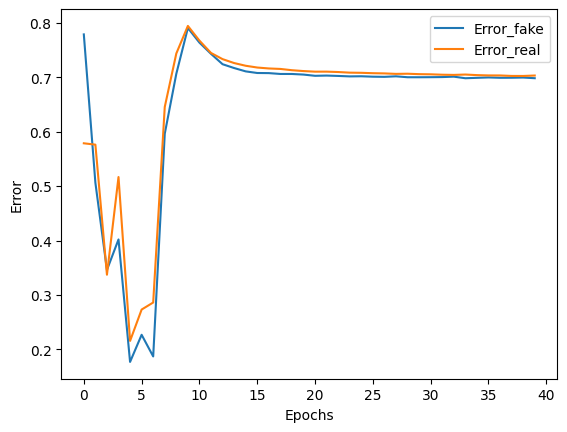

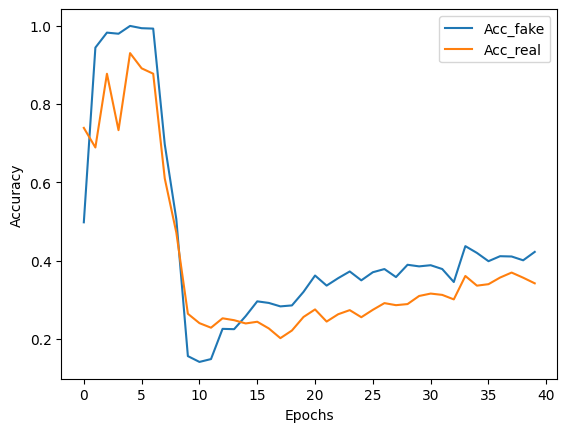

In [33]:
# -- 誤差の推移 --
plt.plot(range(len(error_record_fake)), error_record_fake, label="Error_fake")
plt.plot(range(len(error_record_real)), error_record_real, label="Error_real")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# -- 正解率の推移 --
plt.plot(range(len(acc_record_fake)), acc_record_fake, label="Acc_fake")
plt.plot(range(len(acc_record_real)), acc_record_real, label="Acc_real")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

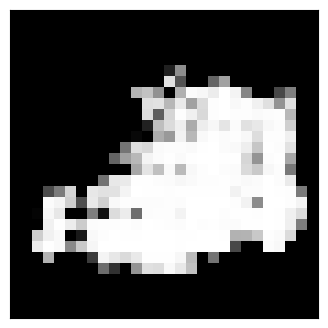

In [54]:
# 1枚の画像を生成
noise = torch.randn(1, n_noise).cuda()  # 1つのノイズベクトルを生成し、GPUに移動
generator.cuda()  # generatorモデルもGPUに移動
img = generator(noise)
img = img.cpu().detach().numpy().reshape(image_size, image_size)  # 結果をCPUに戻し、形状を変換

# 生成画像の表示
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap="Greys_r", vmin=0.0, vmax=1.0)
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()